<a href="https://colab.research.google.com/github/tsai-praveen/tsai-assignments/blob/main/S6/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Actual Code (from class)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

from model import Net

In [3]:
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and standard deviation for normalization
print('[Train]')
print(' - Numpy Shape : ', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2))/255.)
print(' - max:', np.max(exp_data, axis=(0,1,2))/255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2))/255.)
print(' - std:', np.std(exp_data, axis=(0,1,2))/255.)
print(' - var:', np.var(exp_data, axis=(0,1,2))/255.)

Files already downloaded and verified
[Train]
 - Numpy Shape :  (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [4]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
def viz_data(cols=8, rows=5):
    figure = plt.figure(figsize=(14, 10))
    for i in range(1, cols*rows+1):
        img, label = exp[i]

        figure.add_subplot(rows, cols, i)
        plt.title(exp.classes[label])
        plt.axis('off')
        plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()


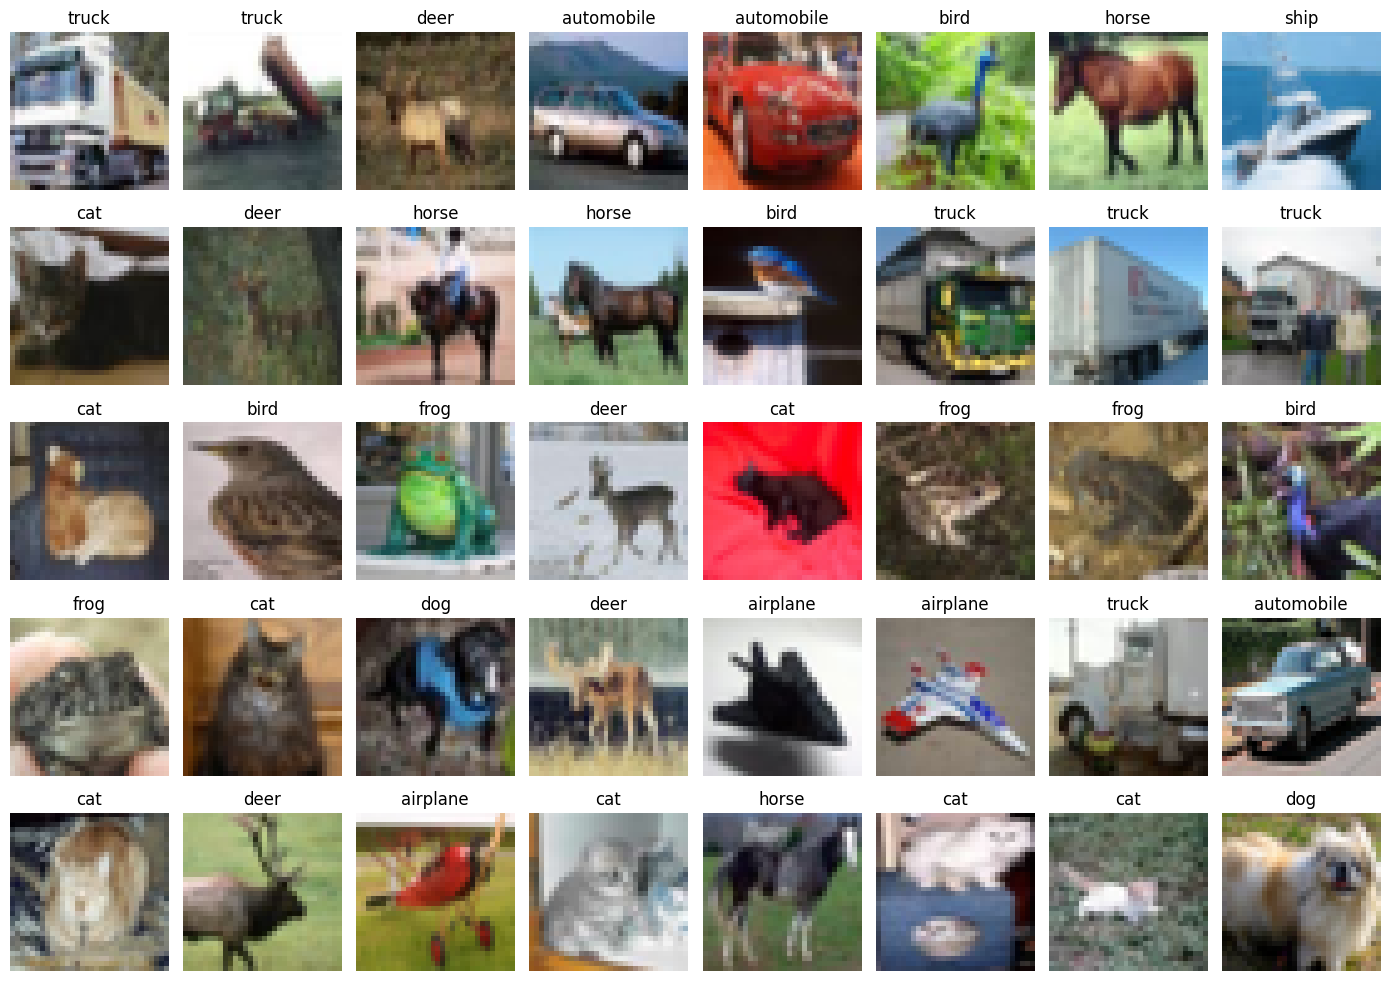

In [6]:
viz_data()

In [7]:
def show_images(aug_dict, ncol=6):
    nrow = len(aug_dict)

    fig, axes = plt.subplots(ncol, nrow, figsize=(3*nrow, 15), squeeze=False)

    for i, (key, aug) in enumerate(aug_dict.items()):
        for j in range(ncol):
            ax = axes[j, i]
            if j==0:
                ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                ax.axis('off')
            else:
                image, label = exp[j-1]
                if aug is not None:
                    transform = A.Compose([aug])
                    image = np.array(image)
                    image = transform(image=image)['image']

                ax.imshow(image)
                ax.set_title(f'{exp.classes[label]}')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

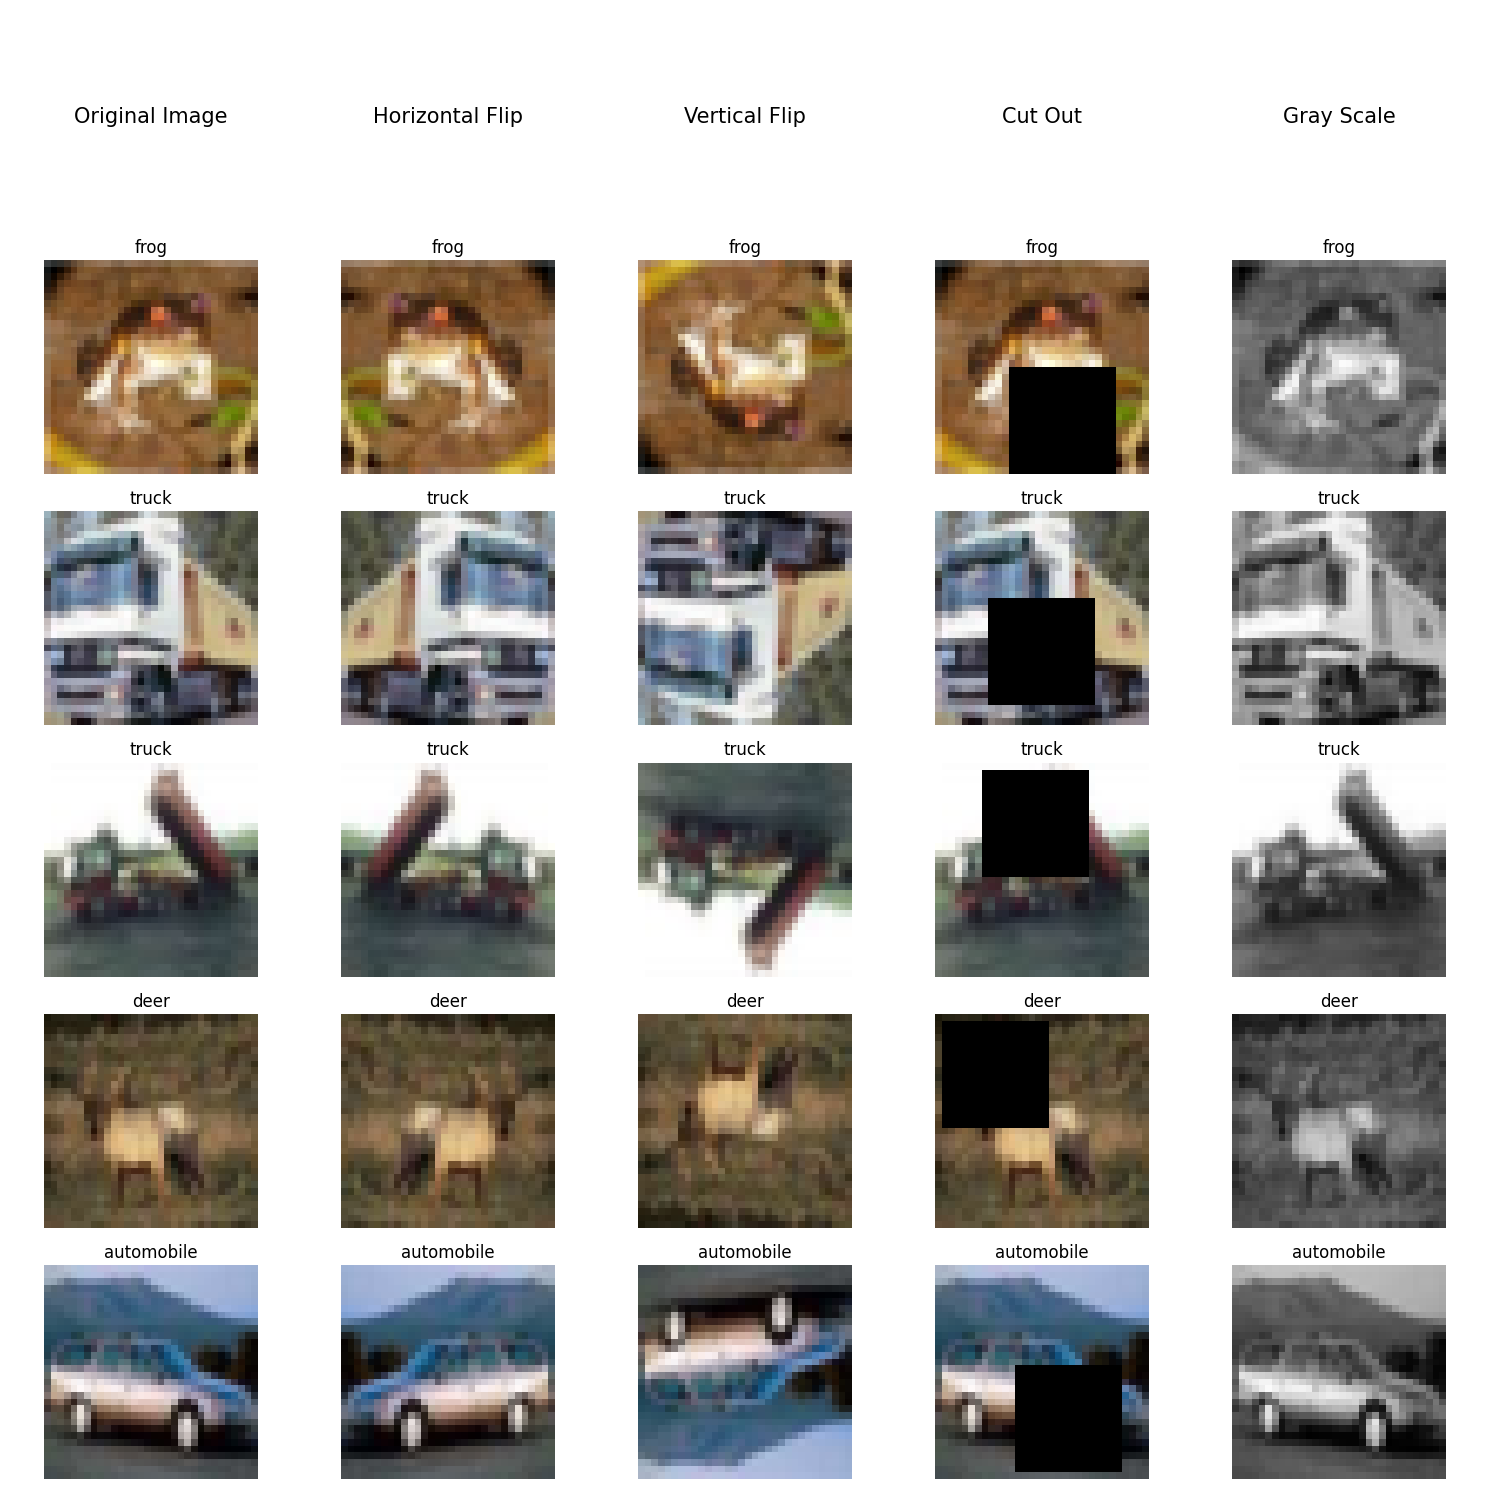

In [8]:
show_images({
    'Original Image' : None, 
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)    
})

In [11]:
class AlbumentationImageDataset(Dataset):
    def __init__(self, image_list, train=True):
        self.image_list = image_list
        self.aug = A.Compose({
            A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
            A.HorizontalFlip(),
            A.ShiftScaleRotate(),
            A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                               min_width=16, fill_value=0.473363, mask_fill_value=None),
            A.ToGray()
        })

        self.norm = A.Compose({
            A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
        })

        self.train = train

    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self, i):
        image, label = self.image_list[i]

        if self.train:
            image = self.aug(image=np.array(image))['image']
        else:
            image = self.norm(image = np.array(image))['image']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return torch.tensor(image, dtype=torch.float), label

In [12]:
SEED = 1

# CUDA available?
cuda = torch.cuda.is_available()
print(f"CUDA Available : {cuda}")

# For reproducability
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
BATCH_SIZE = 64




CUDA Available : True


In [13]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [14]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

train_loader = DataLoader(AlbumentationImageDataset(image_list=trainset, train=True), batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(AlbumentationImageDataset(image_list=testset, train=False), batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

net = Net().to(device)
summary(model=net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

In [16]:
enumerate(train_loader)
# pbar = tqdm(train_loader)
# for batch_idx, (data, target) in enumerate(pbar):
#     print(batch_idx)
#     break

In [21]:
def train(model, device, train_loader, optimizer, l1, scheduler):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    num_loops = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # In pytorch, we need to set the gradient to zero before starting to do backpropagation
        # Because pytorch will accumulate the gradients on subsequent passes. 
        # Hence, when you start training loop, zero out your gradients so that parameter update is done correctly

        # Predict 
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        lambda_l1 = 0.01

        if l1:
            for p in model.parameter():
                l1 = l1 + p.abs().sum()

        loss = loss + lambda_l1*l1

        # Backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update LR
        scheduler.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        num_loops += 1
        pbar.set_description(desc=f"Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100 * correct / processed:0.2f}")

    return 100*correct/processed, train_loss/num_loops


In [22]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdims=True) # get the index of the max log probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss
                            


In [23]:
def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()

    if l2:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    for epoch in range(1, NUM_EPOCHS+1):
        print(f"EPOCH : {epoch}")
        train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
        test_acc, test_loss = test(net, device, test_loader)

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)

    return net, (training_acc, training_loss, testing_acc, testing_loss)

In [24]:
net, history = fit_model(net.to(device), NUM_EPOCHS=100)

EPOCH : 1


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=2.00008 Accuracy=24.35: 100%|██████████| 782/782 [00:22<00:00, 34.01it/s]



 Test set: Average loss: 1.6311, Accuracy: 3812/10000 (38.12%)

EPOCH : 2


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.68428 Accuracy=37.39: 100%|██████████| 782/782 [00:23<00:00, 33.98it/s]



 Test set: Average loss: 1.3576, Accuracy: 5058/10000 (50.58%)

EPOCH : 3


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.54599 Accuracy=43.60: 100%|██████████| 782/782 [00:22<00:00, 34.58it/s]



 Test set: Average loss: 1.2093, Accuracy: 5566/10000 (55.66%)

EPOCH : 4


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.44432 Accuracy=47.80: 100%|██████████| 782/782 [00:23<00:00, 33.93it/s]



 Test set: Average loss: 1.2707, Accuracy: 5636/10000 (56.36%)

EPOCH : 5


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.35996 Accuracy=51.23: 100%|██████████| 782/782 [00:22<00:00, 34.15it/s]



 Test set: Average loss: 1.0659, Accuracy: 6254/10000 (62.54%)

EPOCH : 6


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.29653 Accuracy=54.05: 100%|██████████| 782/782 [00:22<00:00, 34.01it/s]



 Test set: Average loss: 1.0006, Accuracy: 6500/10000 (65.00%)

EPOCH : 7


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.24025 Accuracy=56.26: 100%|██████████| 782/782 [00:22<00:00, 34.29it/s]



 Test set: Average loss: 0.9402, Accuracy: 6729/10000 (67.29%)

EPOCH : 8


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.20645 Accuracy=57.43: 100%|██████████| 782/782 [00:22<00:00, 34.44it/s]



 Test set: Average loss: 0.9477, Accuracy: 6669/10000 (66.69%)

EPOCH : 9


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.16484 Accuracy=58.89: 100%|██████████| 782/782 [00:22<00:00, 34.28it/s]



 Test set: Average loss: 0.8270, Accuracy: 7101/10000 (71.01%)

EPOCH : 10


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.13927 Accuracy=60.06: 100%|██████████| 782/782 [00:22<00:00, 34.25it/s]



 Test set: Average loss: 0.8737, Accuracy: 6946/10000 (69.46%)

EPOCH : 11


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.11080 Accuracy=61.09: 100%|██████████| 782/782 [00:22<00:00, 34.47it/s]



 Test set: Average loss: 0.8413, Accuracy: 7084/10000 (70.84%)

EPOCH : 12


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.08541 Accuracy=62.13: 100%|██████████| 782/782 [00:22<00:00, 34.57it/s]



 Test set: Average loss: 0.7238, Accuracy: 7489/10000 (74.89%)

EPOCH : 13


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.05430 Accuracy=63.17: 100%|██████████| 782/782 [00:22<00:00, 34.22it/s]



 Test set: Average loss: 0.7375, Accuracy: 7415/10000 (74.15%)

EPOCH : 14


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.04831 Accuracy=63.44: 100%|██████████| 782/782 [00:22<00:00, 34.26it/s]



 Test set: Average loss: 0.7356, Accuracy: 7495/10000 (74.95%)

EPOCH : 15


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.02480 Accuracy=64.23: 100%|██████████| 782/782 [00:22<00:00, 34.21it/s]



 Test set: Average loss: 0.7421, Accuracy: 7448/10000 (74.48%)

EPOCH : 16


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=1.00117 Accuracy=65.24: 100%|██████████| 782/782 [00:22<00:00, 34.13it/s]



 Test set: Average loss: 0.6867, Accuracy: 7642/10000 (76.42%)

EPOCH : 17


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.99453 Accuracy=65.32: 100%|██████████| 782/782 [00:23<00:00, 33.73it/s]



 Test set: Average loss: 0.7132, Accuracy: 7527/10000 (75.27%)

EPOCH : 18


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.97203 Accuracy=66.14: 100%|██████████| 782/782 [00:23<00:00, 33.76it/s]



 Test set: Average loss: 0.6633, Accuracy: 7695/10000 (76.95%)

EPOCH : 19


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.96617 Accuracy=66.52: 100%|██████████| 782/782 [00:22<00:00, 34.11it/s]



 Test set: Average loss: 0.6626, Accuracy: 7714/10000 (77.14%)

EPOCH : 20


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.95306 Accuracy=67.11: 100%|██████████| 782/782 [00:22<00:00, 34.01it/s]



 Test set: Average loss: 0.6564, Accuracy: 7803/10000 (78.03%)

EPOCH : 21


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.93278 Accuracy=67.53: 100%|██████████| 782/782 [00:23<00:00, 33.97it/s]



 Test set: Average loss: 0.6473, Accuracy: 7753/10000 (77.53%)

EPOCH : 22


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.93028 Accuracy=67.50: 100%|██████████| 782/782 [00:22<00:00, 34.30it/s]



 Test set: Average loss: 0.6075, Accuracy: 7972/10000 (79.72%)

EPOCH : 23


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.91859 Accuracy=68.20: 100%|██████████| 782/782 [00:23<00:00, 33.61it/s]



 Test set: Average loss: 0.6283, Accuracy: 7854/10000 (78.54%)

EPOCH : 24


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.90220 Accuracy=68.65: 100%|██████████| 782/782 [00:23<00:00, 33.07it/s]



 Test set: Average loss: 0.6094, Accuracy: 7937/10000 (79.37%)

EPOCH : 25


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.90682 Accuracy=68.51: 100%|██████████| 782/782 [00:23<00:00, 33.22it/s]



 Test set: Average loss: 0.6027, Accuracy: 7961/10000 (79.61%)

EPOCH : 26


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.89062 Accuracy=68.93: 100%|██████████| 782/782 [00:23<00:00, 33.57it/s]



 Test set: Average loss: 0.6135, Accuracy: 7888/10000 (78.88%)

EPOCH : 27


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.87776 Accuracy=69.45: 100%|██████████| 782/782 [00:23<00:00, 33.30it/s]



 Test set: Average loss: 0.6203, Accuracy: 7903/10000 (79.03%)

EPOCH : 28


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.87107 Accuracy=69.65: 100%|██████████| 782/782 [00:23<00:00, 32.84it/s]



 Test set: Average loss: 0.5748, Accuracy: 8058/10000 (80.58%)

EPOCH : 29


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.86289 Accuracy=69.88: 100%|██████████| 782/782 [00:23<00:00, 33.34it/s]



 Test set: Average loss: 0.5342, Accuracy: 8185/10000 (81.85%)

EPOCH : 30


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.85917 Accuracy=70.09: 100%|██████████| 782/782 [00:23<00:00, 33.06it/s]



 Test set: Average loss: 0.5717, Accuracy: 8055/10000 (80.55%)

EPOCH : 31


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.85099 Accuracy=70.27: 100%|██████████| 782/782 [00:23<00:00, 33.95it/s]



 Test set: Average loss: 0.6179, Accuracy: 7919/10000 (79.19%)

EPOCH : 32


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.84113 Accuracy=70.79: 100%|██████████| 782/782 [00:22<00:00, 34.89it/s]



 Test set: Average loss: 0.5349, Accuracy: 8169/10000 (81.69%)

EPOCH : 33


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.83578 Accuracy=70.94: 100%|██████████| 782/782 [00:22<00:00, 34.58it/s]



 Test set: Average loss: 0.5590, Accuracy: 8113/10000 (81.13%)

EPOCH : 34


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.83606 Accuracy=70.72: 100%|██████████| 782/782 [00:23<00:00, 33.60it/s]



 Test set: Average loss: 0.5710, Accuracy: 8052/10000 (80.52%)

EPOCH : 35


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.82758 Accuracy=71.22: 100%|██████████| 782/782 [00:23<00:00, 33.89it/s]



 Test set: Average loss: 0.5270, Accuracy: 8209/10000 (82.09%)

EPOCH : 36


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.82139 Accuracy=71.33: 100%|██████████| 782/782 [00:23<00:00, 33.49it/s]



 Test set: Average loss: 0.5062, Accuracy: 8243/10000 (82.43%)

EPOCH : 37


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.81570 Accuracy=71.43: 100%|██████████| 782/782 [00:23<00:00, 33.61it/s]



 Test set: Average loss: 0.5060, Accuracy: 8282/10000 (82.82%)

EPOCH : 38


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.81086 Accuracy=72.00: 100%|██████████| 782/782 [00:23<00:00, 33.60it/s]



 Test set: Average loss: 0.5228, Accuracy: 8218/10000 (82.18%)

EPOCH : 39


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.80196 Accuracy=71.92: 100%|██████████| 782/782 [00:23<00:00, 33.31it/s]



 Test set: Average loss: 0.5559, Accuracy: 8103/10000 (81.03%)

EPOCH : 40


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.79847 Accuracy=72.33: 100%|██████████| 782/782 [00:23<00:00, 33.24it/s]



 Test set: Average loss: 0.5395, Accuracy: 8200/10000 (82.00%)

EPOCH : 41


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.79414 Accuracy=72.21: 100%|██████████| 782/782 [00:23<00:00, 33.19it/s]



 Test set: Average loss: 0.5168, Accuracy: 8238/10000 (82.38%)

EPOCH : 42


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.78776 Accuracy=72.50: 100%|██████████| 782/782 [00:23<00:00, 33.30it/s]



 Test set: Average loss: 0.5004, Accuracy: 8258/10000 (82.58%)

EPOCH : 43


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.79145 Accuracy=72.20: 100%|██████████| 782/782 [00:23<00:00, 33.36it/s]



 Test set: Average loss: 0.5166, Accuracy: 8241/10000 (82.41%)

EPOCH : 44


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.78340 Accuracy=72.63: 100%|██████████| 782/782 [00:23<00:00, 33.05it/s]



 Test set: Average loss: 0.4863, Accuracy: 8352/10000 (83.52%)

EPOCH : 45


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.78158 Accuracy=72.70: 100%|██████████| 782/782 [00:24<00:00, 31.76it/s]



 Test set: Average loss: 0.4832, Accuracy: 8409/10000 (84.09%)

EPOCH : 46


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.77569 Accuracy=72.91: 100%|██████████| 782/782 [00:24<00:00, 32.14it/s]



 Test set: Average loss: 0.5060, Accuracy: 8289/10000 (82.89%)

EPOCH : 47


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.77054 Accuracy=73.24: 100%|██████████| 782/782 [00:23<00:00, 33.11it/s]



 Test set: Average loss: 0.4856, Accuracy: 8360/10000 (83.60%)

EPOCH : 48


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.76545 Accuracy=73.28: 100%|██████████| 782/782 [00:24<00:00, 32.33it/s]



 Test set: Average loss: 0.4883, Accuracy: 8361/10000 (83.61%)

EPOCH : 49


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.76494 Accuracy=73.22: 100%|██████████| 782/782 [00:23<00:00, 33.84it/s]



 Test set: Average loss: 0.5051, Accuracy: 8274/10000 (82.74%)

EPOCH : 50


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.76082 Accuracy=73.14: 100%|██████████| 782/782 [00:23<00:00, 33.52it/s]



 Test set: Average loss: 0.4711, Accuracy: 8391/10000 (83.91%)

EPOCH : 51


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.75536 Accuracy=73.57: 100%|██████████| 782/782 [00:23<00:00, 33.71it/s]



 Test set: Average loss: 0.4708, Accuracy: 8446/10000 (84.46%)

EPOCH : 52


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.75591 Accuracy=73.75: 100%|██████████| 782/782 [00:23<00:00, 32.85it/s]



 Test set: Average loss: 0.4733, Accuracy: 8370/10000 (83.70%)

EPOCH : 53


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.75258 Accuracy=73.73: 100%|██████████| 782/782 [00:23<00:00, 32.72it/s]



 Test set: Average loss: 0.4665, Accuracy: 8405/10000 (84.05%)

EPOCH : 54


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.74652 Accuracy=73.79: 100%|██████████| 782/782 [00:24<00:00, 32.37it/s]



 Test set: Average loss: 0.4677, Accuracy: 8424/10000 (84.24%)

EPOCH : 55


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.74379 Accuracy=73.98: 100%|██████████| 782/782 [00:23<00:00, 32.79it/s]



 Test set: Average loss: 0.4599, Accuracy: 8416/10000 (84.16%)

EPOCH : 56


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.74171 Accuracy=74.23: 100%|██████████| 782/782 [00:23<00:00, 32.81it/s]



 Test set: Average loss: 0.4602, Accuracy: 8442/10000 (84.42%)

EPOCH : 57


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.73563 Accuracy=74.31: 100%|██████████| 782/782 [00:24<00:00, 32.42it/s]



 Test set: Average loss: 0.4557, Accuracy: 8477/10000 (84.77%)

EPOCH : 58


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.73789 Accuracy=74.38: 100%|██████████| 782/782 [00:23<00:00, 32.87it/s]



 Test set: Average loss: 0.4474, Accuracy: 8456/10000 (84.56%)

EPOCH : 59


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.72701 Accuracy=74.56: 100%|██████████| 782/782 [00:24<00:00, 32.21it/s]



 Test set: Average loss: 0.4354, Accuracy: 8523/10000 (85.23%)

EPOCH : 60


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.72414 Accuracy=74.63: 100%|██████████| 782/782 [00:23<00:00, 32.68it/s]



 Test set: Average loss: 0.4437, Accuracy: 8482/10000 (84.82%)

EPOCH : 61


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.71775 Accuracy=75.10: 100%|██████████| 782/782 [00:23<00:00, 32.71it/s]



 Test set: Average loss: 0.4379, Accuracy: 8521/10000 (85.21%)

EPOCH : 62


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.71604 Accuracy=75.03: 100%|██████████| 782/782 [00:23<00:00, 32.87it/s]



 Test set: Average loss: 0.4313, Accuracy: 8506/10000 (85.06%)

EPOCH : 63


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.71575 Accuracy=74.94: 100%|██████████| 782/782 [00:24<00:00, 32.49it/s]



 Test set: Average loss: 0.4553, Accuracy: 8406/10000 (84.06%)

EPOCH : 64


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.71100 Accuracy=75.11: 100%|██████████| 782/782 [00:23<00:00, 33.38it/s]



 Test set: Average loss: 0.4476, Accuracy: 8474/10000 (84.74%)

EPOCH : 65


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.70808 Accuracy=75.27: 100%|██████████| 782/782 [00:23<00:00, 33.60it/s]



 Test set: Average loss: 0.4365, Accuracy: 8507/10000 (85.07%)

EPOCH : 66


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.70702 Accuracy=75.37: 100%|██████████| 782/782 [00:24<00:00, 32.31it/s]



 Test set: Average loss: 0.4355, Accuracy: 8536/10000 (85.36%)

EPOCH : 67


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.70153 Accuracy=75.53: 100%|██████████| 782/782 [00:24<00:00, 32.56it/s]



 Test set: Average loss: 0.4375, Accuracy: 8503/10000 (85.03%)

EPOCH : 68


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.70154 Accuracy=75.73: 100%|██████████| 782/782 [00:24<00:00, 31.49it/s]



 Test set: Average loss: 0.4295, Accuracy: 8570/10000 (85.70%)

EPOCH : 69


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.69836 Accuracy=75.70: 100%|██████████| 782/782 [00:24<00:00, 32.33it/s]



 Test set: Average loss: 0.4235, Accuracy: 8572/10000 (85.72%)

EPOCH : 70


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.68950 Accuracy=75.80: 100%|██████████| 782/782 [00:24<00:00, 32.02it/s]



 Test set: Average loss: 0.4218, Accuracy: 8580/10000 (85.80%)

EPOCH : 71


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.69052 Accuracy=75.80: 100%|██████████| 782/782 [00:24<00:00, 31.81it/s]



 Test set: Average loss: 0.4306, Accuracy: 8552/10000 (85.52%)

EPOCH : 72


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.68256 Accuracy=75.96: 100%|██████████| 782/782 [00:24<00:00, 31.57it/s]



 Test set: Average loss: 0.4190, Accuracy: 8585/10000 (85.85%)

EPOCH : 73


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.67690 Accuracy=76.35: 100%|██████████| 782/782 [00:23<00:00, 32.66it/s]



 Test set: Average loss: 0.4275, Accuracy: 8553/10000 (85.53%)

EPOCH : 74


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.68103 Accuracy=76.19: 100%|██████████| 782/782 [00:24<00:00, 31.86it/s]



 Test set: Average loss: 0.4184, Accuracy: 8581/10000 (85.81%)

EPOCH : 75


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.67738 Accuracy=76.36: 100%|██████████| 782/782 [00:23<00:00, 33.17it/s]



 Test set: Average loss: 0.4222, Accuracy: 8577/10000 (85.77%)

EPOCH : 76


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.67239 Accuracy=76.50: 100%|██████████| 782/782 [00:24<00:00, 32.33it/s]



 Test set: Average loss: 0.4119, Accuracy: 8594/10000 (85.94%)

EPOCH : 77


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.67283 Accuracy=76.33: 100%|██████████| 782/782 [00:25<00:00, 30.64it/s]



 Test set: Average loss: 0.4230, Accuracy: 8570/10000 (85.70%)

EPOCH : 78


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.66729 Accuracy=76.67: 100%|██████████| 782/782 [00:25<00:00, 30.15it/s]



 Test set: Average loss: 0.4200, Accuracy: 8584/10000 (85.84%)

EPOCH : 79


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.66823 Accuracy=76.44: 100%|██████████| 782/782 [00:24<00:00, 31.35it/s]



 Test set: Average loss: 0.4015, Accuracy: 8655/10000 (86.55%)

EPOCH : 80


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.65850 Accuracy=76.88: 100%|██████████| 782/782 [00:25<00:00, 31.25it/s]



 Test set: Average loss: 0.4075, Accuracy: 8613/10000 (86.13%)

EPOCH : 81


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.65889 Accuracy=76.86: 100%|██████████| 782/782 [00:25<00:00, 30.79it/s]



 Test set: Average loss: 0.3997, Accuracy: 8639/10000 (86.39%)

EPOCH : 82


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.66141 Accuracy=76.95: 100%|██████████| 782/782 [00:23<00:00, 32.68it/s]



 Test set: Average loss: 0.4034, Accuracy: 8622/10000 (86.22%)

EPOCH : 83


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.65045 Accuracy=77.16: 100%|██████████| 782/782 [00:24<00:00, 32.02it/s]



 Test set: Average loss: 0.4025, Accuracy: 8625/10000 (86.25%)

EPOCH : 84


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.64853 Accuracy=77.37: 100%|██████████| 782/782 [00:24<00:00, 31.91it/s]



 Test set: Average loss: 0.3900, Accuracy: 8677/10000 (86.77%)

EPOCH : 85


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.64251 Accuracy=77.61: 100%|██████████| 782/782 [00:24<00:00, 31.33it/s]



 Test set: Average loss: 0.3913, Accuracy: 8680/10000 (86.80%)

EPOCH : 86


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.63413 Accuracy=77.66: 100%|██████████| 782/782 [00:24<00:00, 31.42it/s]



 Test set: Average loss: 0.3937, Accuracy: 8666/10000 (86.66%)

EPOCH : 87


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.63608 Accuracy=77.77: 100%|██████████| 782/782 [00:25<00:00, 30.63it/s]



 Test set: Average loss: 0.3914, Accuracy: 8680/10000 (86.80%)

EPOCH : 88


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.62958 Accuracy=77.97: 100%|██████████| 782/782 [00:25<00:00, 30.88it/s]



 Test set: Average loss: 0.3864, Accuracy: 8685/10000 (86.85%)

EPOCH : 89


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.63494 Accuracy=77.75: 100%|██████████| 782/782 [00:24<00:00, 31.79it/s]



 Test set: Average loss: 0.3850, Accuracy: 8699/10000 (86.99%)

EPOCH : 90


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.62581 Accuracy=78.04: 100%|██████████| 782/782 [00:24<00:00, 31.85it/s]



 Test set: Average loss: 0.3809, Accuracy: 8713/10000 (87.13%)

EPOCH : 91


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.62616 Accuracy=78.13: 100%|██████████| 782/782 [00:24<00:00, 32.54it/s]



 Test set: Average loss: 0.3829, Accuracy: 8694/10000 (86.94%)

EPOCH : 92


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61989 Accuracy=78.25: 100%|██████████| 782/782 [00:24<00:00, 31.37it/s]



 Test set: Average loss: 0.3848, Accuracy: 8721/10000 (87.21%)

EPOCH : 93


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.62327 Accuracy=78.13: 100%|██████████| 782/782 [00:24<00:00, 31.55it/s]



 Test set: Average loss: 0.3809, Accuracy: 8712/10000 (87.12%)

EPOCH : 94


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61431 Accuracy=78.51: 100%|██████████| 782/782 [00:26<00:00, 29.91it/s]



 Test set: Average loss: 0.3788, Accuracy: 8721/10000 (87.21%)

EPOCH : 95


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61911 Accuracy=78.25: 100%|██████████| 782/782 [00:25<00:00, 30.74it/s]



 Test set: Average loss: 0.3797, Accuracy: 8725/10000 (87.25%)

EPOCH : 96


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61608 Accuracy=78.54: 100%|██████████| 782/782 [00:25<00:00, 31.06it/s]



 Test set: Average loss: 0.3820, Accuracy: 8723/10000 (87.23%)

EPOCH : 97


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61372 Accuracy=78.67: 100%|██████████| 782/782 [00:24<00:00, 31.88it/s]



 Test set: Average loss: 0.3783, Accuracy: 8718/10000 (87.18%)

EPOCH : 98


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61220 Accuracy=78.62: 100%|██████████| 782/782 [00:24<00:00, 31.95it/s]



 Test set: Average loss: 0.3769, Accuracy: 8723/10000 (87.23%)

EPOCH : 99


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.61378 Accuracy=78.29: 100%|██████████| 782/782 [00:25<00:00, 31.13it/s]



 Test set: Average loss: 0.3776, Accuracy: 8722/10000 (87.22%)

EPOCH : 100


  0%|          | 0/782 [00:00<?, ?it/s]

Got to training....


Batch_id=781 Loss=0.60442 Accuracy=78.85: 100%|██████████| 782/782 [00:24<00:00, 31.35it/s]



 Test set: Average loss: 0.3796, Accuracy: 8725/10000 (87.25%)

